In [1]:
!pip install kaggle

In [0]:
!mkdir saved_models

In [0]:
!mkdir .kaggle

In [0]:
!mkdir /root/.kaggle

In [0]:
import json
token = {"username":"shlok97","key":"ENTER-YOUR-KEY-HERE"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [7]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d gasgallo/faces-data-new

 91% 41.0M/44.9M [00:00<00:00, 41.8MB/s]
100% 44.9M/44.9M [00:00<00:00, 54.3MB/s]


In [10]:
!unzip {/content}/datasets/gasgallo/faces-data-new/faces-data-new.zip

Archive:  {/content}/datasets/gasgallo/faces-data-new/faces-data-new.zip
   creating: images/
  inflating: images/9326871.1.jpg    
  inflating: images/9326871.10.jpg   
  inflating: images/9326871.11.jpg   
  inflating: images/9326871.12.jpg   
  inflating: images/9326871.13.jpg   
  inflating: images/9326871.14.jpg   
  inflating: images/9326871.15.jpg   
  inflating: images/9326871.16.jpg   
  inflating: images/9326871.17.jpg   
  inflating: images/9326871.18.jpg   
  inflating: images/9326871.19.jpg   
  inflating: images/9326871.2.jpg    
  inflating: images/9326871.20.jpg   
  inflating: images/9326871.3.jpg    
  inflating: images/9326871.4.jpg    
  inflating: images/9326871.5.jpg    
  inflating: images/9326871.6.jpg    
  inflating: images/9326871.7.jpg    
  inflating: images/9326871.8.jpg    
  inflating: images/9326871.9.jpg    
  inflating: images/9332898.1.jpg    
  inflating: images/9332898.10.jpg   
  inflating: images/9332898.11.jpg   
  inflating: images/9332898.12.j

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper

%matplotlib inline

In [0]:
tf.reset_default_graph()
def attention(x, ch, scope, reuse=False):
  with tf.variable_scope(scope) as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        f = tf.layers.conv2d(
            x,
            ch // 8,
            1,
            strides=1
        )
        g = tf.layers.conv2d(
            x,
            ch // 8,
            1,
            strides=1
        )
        h = tf.layers.conv2d(
            x,
            ch,
            1,
            strides=1
        )
        # N = h * w
        s = tf.matmul(tf.layers.flatten(g), tf.layers.flatten(f), transpose_b=True) # # [bs, N, N]

        beta = tf.nn.softmax(s)  # attention map

        o = tf.matmul(beta, tf.layers.flatten(h)) # [bs, N, C]
        gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

        o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
        x = gamma * o + x

        return x

In [0]:
def generator(z, batch_size, isTraining = True, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 3 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 64 #Output size of the image
        
        # input size [1, 100]
        kernel_size = 3
        h0 = tf.reshape(z, [batch_size, 1, 100])
        h0 = tf.nn.relu(h0)
        
        h1 = tf.layers.dense(z, 1024*4*4, activation=tf.nn.relu, reuse=reuse)
#         h1 = tf.keras.layers.Dense(256*4*4, activation=tf.nn.relu)(z)
        h1 = tf.reshape(h1, ([batch_size, 4, 4, 1024]))
        

        h2 = tf.layers.conv2d_transpose(
            h1,
            512,
            kernel_size,
            strides=(2, 2),
            padding='same',
        )
        h2 = tf.layers.batch_normalization(h2, training=isTraining)
        
        h2 = tf.nn.leaky_relu(
            h2,
            alpha=0.01,
        )
        
#         h2 = attention(h2, 512, scope='g_attn_1', reuse=reuse)
        
        h3 = tf.layers.conv2d_transpose(
            h2,
            256,
            kernel_size,
            strides=(2, 2),
            padding='same',
        )
        h3 = tf.layers.batch_normalization(h3, training=isTraining)
        h3 = tf.nn.leaky_relu(
            h3,
            alpha=0.01,
        )
#         h3 = attention(h3, 256, scope='g_attn_2', reuse=reuse)

        
        h4 = tf.layers.conv2d_transpose(
            h3,
            128,
            kernel_size,
            strides=(2, 2),
            padding='same',
        )
        h4 = tf.layers.batch_normalization(h4, training=isTraining)
        h4 = tf.nn.leaky_relu(
            h4,
            alpha=0.01,
        )
        
        # ATTENTION LAYER
        
        h4 = attention(h4, 128, scope='g_attn_3', reuse=reuse)
        
        h5 = tf.layers.conv2d_transpose(
            h4,
            3,
            kernel_size,
            strides=(2, 2),
            padding='same'
        )
        h5 = tf.layers.batch_normalization(h5, training=isTraining)
        h5 = tf.nn.tanh(
            h5
        )
        
        return h5

In [0]:
def discriminator(x_image, batch_size, reuse=False):
  with tf.variable_scope('discriminator') as scope:
      if (reuse):
          tf.get_variable_scope().reuse_variables()

      img = tf.reshape(x_image, [batch_size, 64, 64, 3])
      
      kernel_size = 7
      conv1 = tf.layers.conv2d(
          img,
          64,
          kernel_size,
          strides=(2, 2),
          padding='same',
          reuse=None
      )
      conv1 = tf.nn.leaky_relu(
        conv1,
        alpha=0.05,
      )

      conv1 = tf.layers.dropout(
        conv1,
        rate=0.3,
      )
      
#       conv1 = attention(conv1, 64, scope='d_attn_1', reuse=reuse)

      conv2 = tf.layers.conv2d(
          conv1,
          128,
          kernel_size,
          strides=(2, 2),
          padding='same',
          reuse=None
      )

      conv2 = tf.nn.leaky_relu(
        conv2,
        alpha=0.05,
      )

      conv2 = tf.layers.dropout(
        conv2,
        rate=0.3,
      )
      
#       ATTENTION LAYER
#       conv2 = attention(conv2, 128, scope='d_attn_2', reuse=reuse)

      conv3 = tf.layers.conv2d(
          conv2,
          256,
          kernel_size,
          strides=(2, 2),
          padding='same',
          reuse=None
      )

      conv3 = tf.nn.leaky_relu(
        conv3,
        alpha=0.05,
      )

      conv3 = tf.layers.dropout(
        conv3,
        rate=0.3,
      )
      conv3 = attention(conv3, 256, scope='d_attn_3', reuse=reuse)

      flat = tf.layers.flatten(
          conv3,
      )

      logits = tf.layers.dense(
        flat,
        1
      )
      output = tf.sigmoid(logits)
      
      return output, logits
  

In [0]:
def loss(input_real, input_z, batch_size):
  label_smoothing = 0.9
  
  
  generated_image = generator(input_z, batch_size)
  
  
  d_output_real, d_logits_real = discriminator(input_real, batch_size)
  d_output_fake, d_logits_fake = discriminator(generated_image, batch_size, reuse=True)
  
  real_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_output_real)*label_smoothing, logits=d_logits_real)
  )
  
  fake_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_output_fake), logits=d_logits_fake)
  )
  
  d_loss =  real_loss + fake_loss
  
  g_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_output_fake)*label_smoothing, logits=d_logits_fake)
  )
  
  return d_loss, g_loss

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
  """
  Show example output for the generator
  """
  z_dim = input_z.get_shape().as_list()[-1]
#   example_z = np.random.uniform(-1, 1, size=[1, z_dim])
  example_z = np.ones(shape=[1, z_dim])*0.1
  
  samples = sess.run(
      generator(input_z, 1, False, True),
      feed_dict={input_z: example_z})

  plt.imshow((samples[0] + 1.)/2.)
  plt.show()

In [0]:
import os
from PIL import Image
import numpy as np

def get_training_data():
    import matplotlib.image as mpimg

    def load_images(folder):
        training_data = []
        
        for filename in os.listdir(folder):
            img = Image.open(os.path.join(folder, filename)).convert('RGB')
            if img is not None:
                img = img.resize((64,64),Image.ANTIALIAS)
                pixel_array = np.asarray(img)
                if pixel_array.shape == (64, 64, 3):
                    training_data.append(pixel_array)
        return training_data
    
    return load_images("images")

In [0]:
training_data = get_training_data()

In [0]:
def get_batch(batch_size=16):
  batch = []
  
  import random
  
  for i in range(batch_size):
    batch.append(training_data[random.randint(0, len(training_data)-1)])
  return (np.array(batch) / 127.5) - 1.0

W0813 05:02:34.302724 140323049482112 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


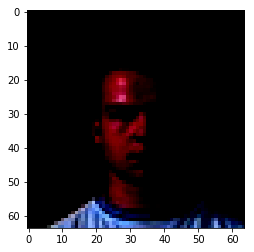

In [21]:
plt.imshow(get_batch()[0])
plt.show()

In [0]:
# (64, 64, 3, 100)

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [0]:
saver = None
def train(epoch_count, batch_size, z_dim, learning_rate, beta1):
    """
    Train the GAN
    """
#     input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    input_real, input_z, _ = model_inputs(64, 64, 3, 100)
    
    d_loss, g_loss = loss(input_real, input_z, batch_size)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    steps = 0
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      for epoch_i in range(epoch_count):

          # values range from -0.5 to 0.5, therefore scale to range -1, 1
          batch_images = get_batch(batch_size)
          steps += 1

          batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

          _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
          _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})


          if steps % 40 == 0:
              # At the end of every 10 epochs, get the losses and print them out
              saver.save(sess, "saved_models/gan.model", global_step=steps)
              train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
              train_loss_g = g_loss.eval({input_z: batch_z})
              saved_session = sess
              print("Epoch {}/{}...".format(epoch_i+1, epochs),
                    "Discriminator Loss: {:.4f}...".format(train_loss_d),
                    "Generator Loss: {:.4f}".format(train_loss_g))

              _ = show_generator_output(sess, 1, input_z, 3)

W0813 05:02:40.931952 140323049482112 deprecation.py:323] From <ipython-input-13-1c5efc1d51c9>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0813 05:02:40.937924 140323049482112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 05:02:41.216671 140323049482112 deprecation.py:323] From <ipython-input-13-1c5efc1d51c9>:24: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
W0813 05:02:41.895842 140323049482112 deprecation.py:323

Epoch 40/6000... Discriminator Loss: 0.3571... Generator Loss: 3.6050


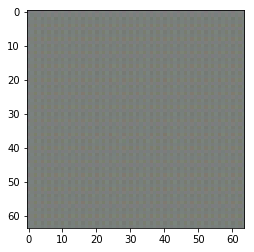

Epoch 80/6000... Discriminator Loss: 0.4231... Generator Loss: 2.7041


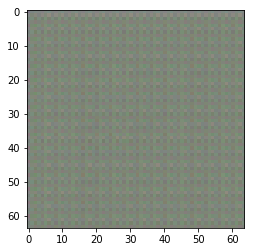

Epoch 120/6000... Discriminator Loss: 0.3719... Generator Loss: 3.2857


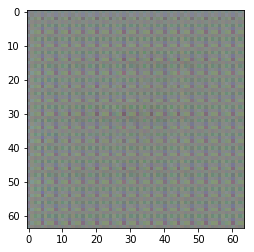

Epoch 160/6000... Discriminator Loss: 0.5596... Generator Loss: 2.6252


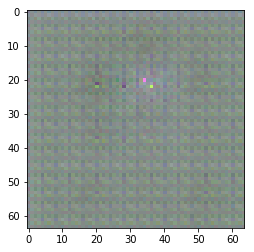

Epoch 200/6000... Discriminator Loss: 0.8394... Generator Loss: 1.4665


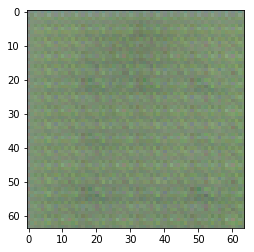

W0813 05:03:09.691399 140323049482112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch 240/6000... Discriminator Loss: 0.7785... Generator Loss: 1.9993


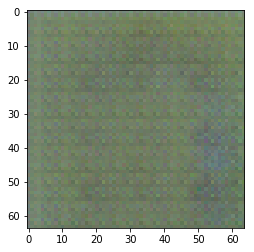

Epoch 280/6000... Discriminator Loss: 0.5955... Generator Loss: 1.9532


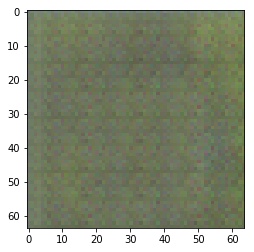

Epoch 320/6000... Discriminator Loss: 0.8153... Generator Loss: 1.1420


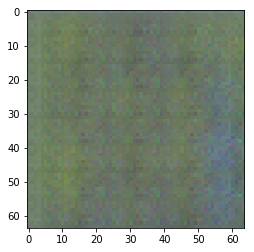

In [0]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 6000

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1)

In [0]:
def load():
  graph = tf.Graph()
  with graph.as_default():
    with tf.Session() as sess:
      t_vars = tf.trainable_variables()
      g_vars = [var for var in t_vars if var.name.startswith('generator')]
      new_saver = tf.train.import_meta_graph('saved_models/gan.model-40.meta')
      new_saver.restore(sess, tf.train.latest_checkpoint('saved_models/'))
      graph.
    

In [0]:
load()

[<tf.Variable 'generator/dense/kernel:0' shape=(100, 16384) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(16384,) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose/kernel:0' shape=(3, 3, 512, 1024) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization/gamma:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization/beta:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose_1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose_1/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_1/gamma:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_1/beta:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose_2/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'generator/conv2d_transpose_2/bias:

In [0]:
# batch_size_placeholder = graph.get_tensor_by_name('batch_size_placeholder:0')
#         features_placeholder = graph.get_tensor_by_name('features_placeholder:0')
#         labels_placeholder = graph.get_tensor_by_name('labels_placeholder:0')
#         prediction = restored_graph.get_tensor_by_name('dense/BiasAdd:0')

#         sess.run(prediction, feed_dict={
#             batch_size_placeholder: some_value,
#             features_placeholder: some_other_value,
#             labels_placeholder: another_value
#         })

NotFoundError: ignored